In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Model
import os
from math import ceil

## Set data paths

In [2]:
data_path = 'Sample data'
spectroscopy_path = os.path.join(data_path, 'Spectroscopy')
loading_path = os.path.join(data_path, 'Loading Time')
temperature_path = os.path.join(data_path, 'Release and Recapture')

## Functions to parse the data

In [3]:
def get_txt_csv(path):
    files = os.listdir(path)
    file_names = [ file for file in files if file.endswith( ('.txt','.TXT','.CSV','.csv') ) ]
    file_paths = [os.path.join(path, file) for file in file_names]
    return file_names, file_paths

def make_oscilloscope_df(path):
    file_names, file_paths = get_txt_csv(path)
    dfs = []
    for file_path, file_name in zip(file_paths, file_names):
        df = pd.read_csv(file_path, header=None)
        df.drop([0,1,2,5], axis=1, inplace=True)
#         df = df.astype(np.float64)
#         df.index = df.index.astype(np.float64)
        df.set_index(3, inplace=True)
        df.index.name = 'time [s]'
        df.columns = [file_name[:-4]]
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    return dfs

def make_spectroscopy_df(path):
    pass

def plot_dfs(dfs):
    plot_columns = ceil(len(dfs)/4)
    fig, axes = plt.subplots(plot_columns,4, figsize=(15, plot_columns*2), facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, df in enumerate(dfs):
        axes[i].plot(df.index,df.values, '.')
    return fig, axes

## Analysing loading curves

### 1 - Starting point

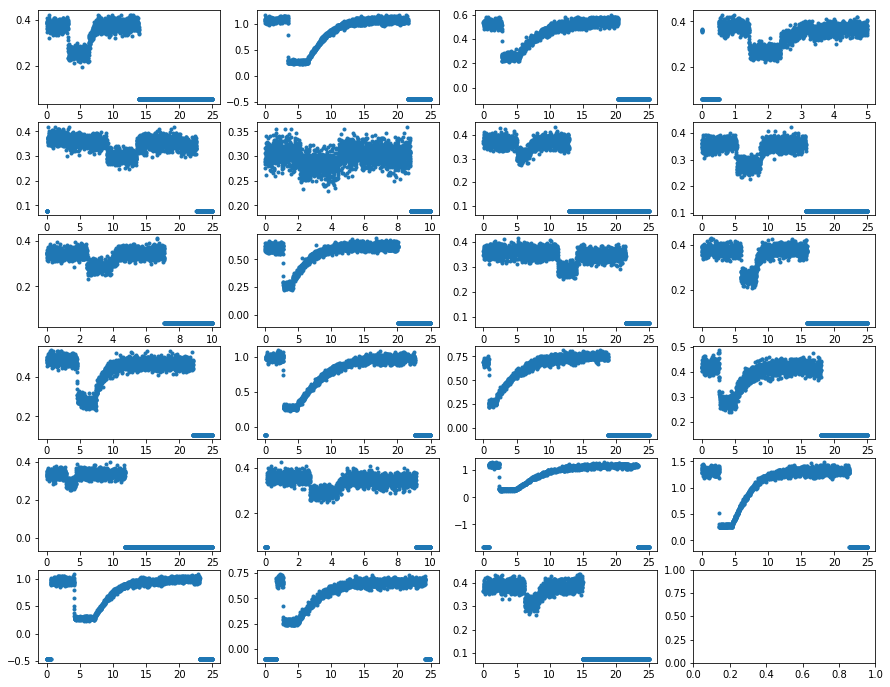

In [4]:
dfs = make_oscilloscope_df(loading_path)
fig, axes = plot_dfs(dfs)
plt.show(fig)

### 2 - Filtering values that are equal to the minimum value

In [5]:
def filter_loading(dfs, rolling=1):
    for i, df in enumerate(dfs):
        dfs[i] = df[df != df.min()].rolling(window=rolling, center=True).mean().dropna()
    return dfs

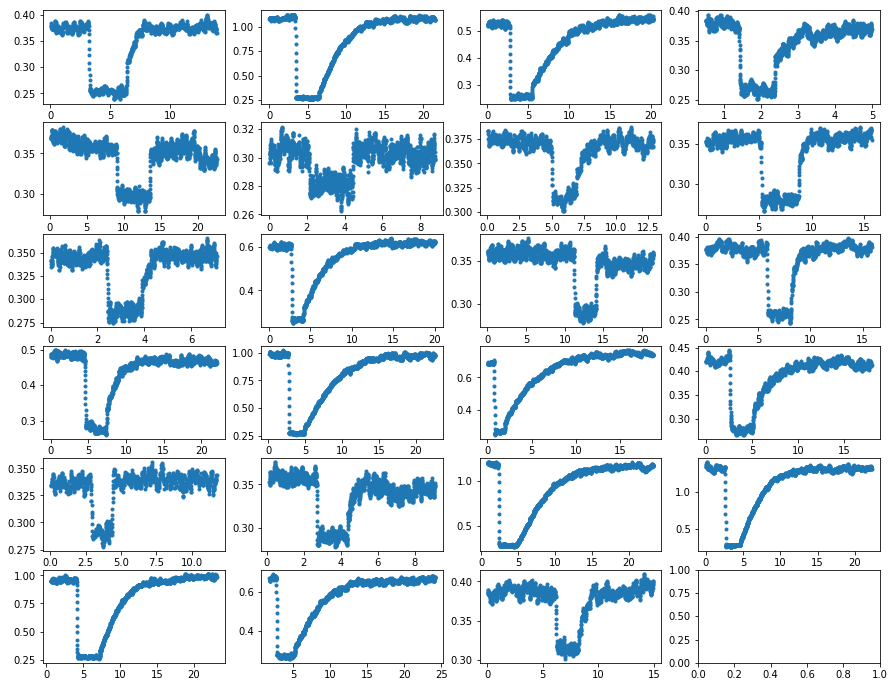

In [6]:
dfs = filter_loading(dfs, rolling=10)
fig, axes = plot_dfs(dfs)
plt.show(fig)

### 3 - Fitting loading curves

In [28]:
from lmfit import Parameters, fit_report, minimize

def loading_residual(pars, x , data=None):
    vals = pars.valuesdict()
    v1 = vals['v1']
    v2 = vals['v2']
    offset = vals['offset']
    t0 = vals['t0']
    dt = vals['dt']
    tau = vals['tau']
    
    model = v2+(v1-v2)*(1-np.exp(-np.abs((x-t0-dt)/tau)))+offset
    model[x <= t0+dt] = v2
    model[x <= t0] = v1
    if data is None:
        return model
    return model - data


def fit_loading_dfs(dfs, offset_on=False):
    fit_data = {
        'file': [df.columns[0] for df in dfs],
        'amp': [],
        'offset': [],
#         'amp_std': [],
        'tau': [],
#         'tau_std': [],
        'redchi': [],
    }
    for i, df in enumerate(dfs):
        x = df.index.values
        y = df.iloc[:,0].values
        
        # predicting parameters
        vmin = np.min(y)
        vmax = np.max(y)
        dv = vmax - vmin
        tmin = np.min(x)
        tmax = np.max(x)
        tscan = tmax - tmin
        
        p = Parameters()
        p.add('v1', value=vmax, min=vmax-dv/10, max=vmax)
        p.add('v2', value=vmin, min=vmin, max=np.min(y)+0.03)
        p.add('offset', value=0, vary=offset_on, min=0, max=dv, brute_step=dv/20)
        p.add('t0', value=tscan/5, min=tmin, max=tmax, brute_step=tscan/20)
        p.add('dt', value=0, min=0, max=tscan, brute_step=tscan/5)
        p.add('tau', value=1, min=0, max=60, brute_step=10)
        
        mi = minimize(loading_residual, p, args=(x,), kws={'data': y}, method='powell')
#         mi = minimize(loading_residual, mi.params, args=(x,), kws={'data': y}, method='leastsq')
        dfs[i]['best fit'] = loading_residual(mi.params, x)
#         dfs[i]['init fit'] = loading_residual(mi.init_values, x)
        
        # storing fit results
        fit_data['amp'].append(mi.params['v1'].value-mi.params['v2'].value)
        fit_data['tau'].append(mi.params['tau'].value)
        fit_data['offset'].append(mi.params['offset'].value)
        fit_data['redchi'].append(mi.redchi)
        
    fit_df = pd.DataFrame(data=fit_data)
    fit_df = fit_df.set_index('file', drop=True).sort_index(level=0)
    return dfs, fit_df

def plot_dfs_with_fits(dfs):
    plot_columns = ceil(len(dfs)/4)
    fig, axes = plt.subplots(plot_columns,4, figsize=(15, plot_columns*2), facecolor='w', edgecolor='k')
    axes = axes.ravel()
    for i, df in enumerate(dfs):
        axes[i].plot(df.index,df.iloc[:,0].values, '.')
#         axes[i].plot(df.index,df['init fit'].values, 'k--')
        axes[i].plot(df.index,df['best fit'].values, 'r-')
    return fig, axes

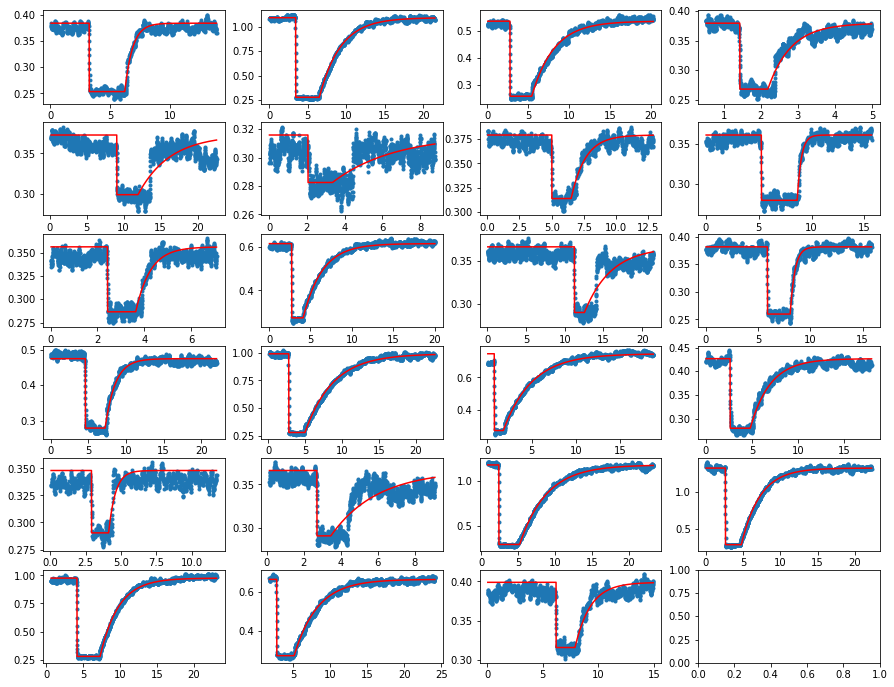

In [29]:
dfs_fit, fit_df = fit_loading_dfs(dfs, offset_on=False)
fig, axes = plot_dfs_with_fits(dfs_fit)

In [127]:
fit_df

,amp,offset,redchi,tau
file,,,,
TEK0000,0.048200,0.016321,0.000253,29.546358
TEK0001,0.066985,0.045535,0.000056,10.000000
TEK0002,0.057117,0.043813,0.000047,16.760889
TEK0003,0.067639,0.051799,0.000035,60.000000
TEK0004,0.062410,0.046647,0.000078,60.000000
TEK0005,0.997389,0.549849,0.009870,16.739888
TEK0006,0.672368,0.278029,0.002738,12.731384
TEK0007,0.411478,0.187680,0.001122,10.000309
TEK0008,0.314892,0.172827,0.000954,13.208546


## Release and Recapture

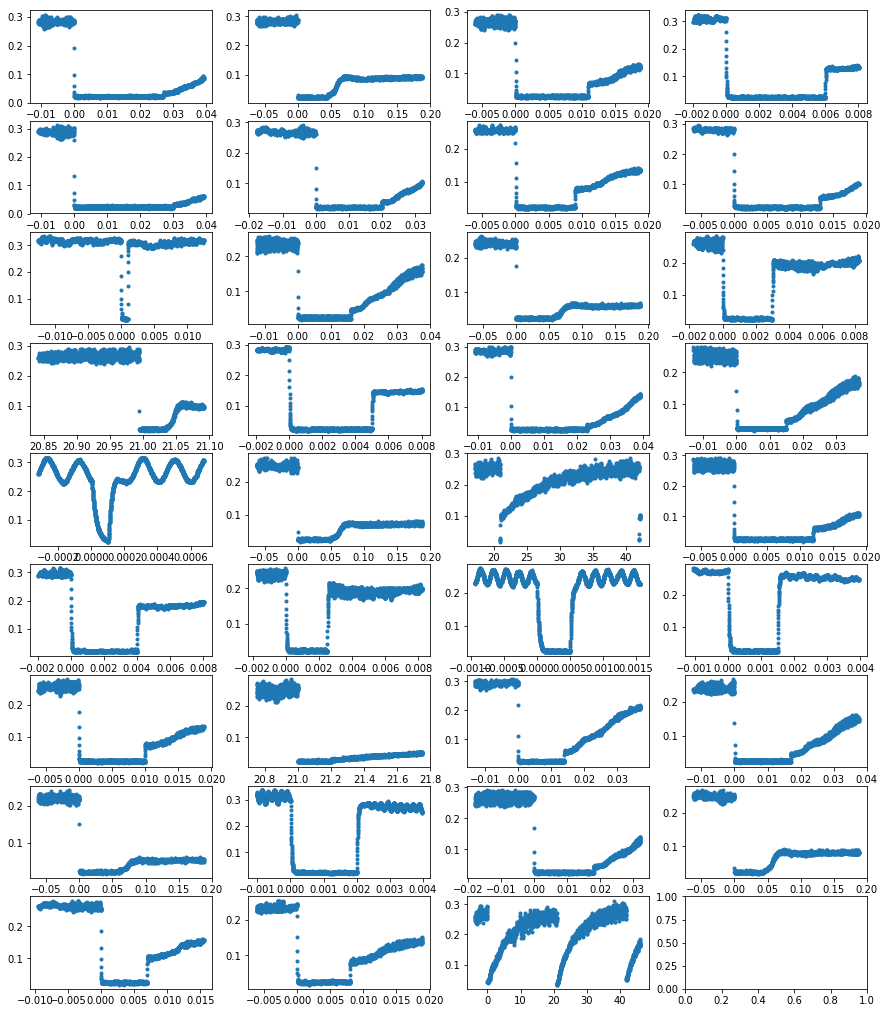

In [12]:
dfs_rr = make_oscilloscope_df(temperature_path)
fig, axes = plot_dfs(dfs_rr)

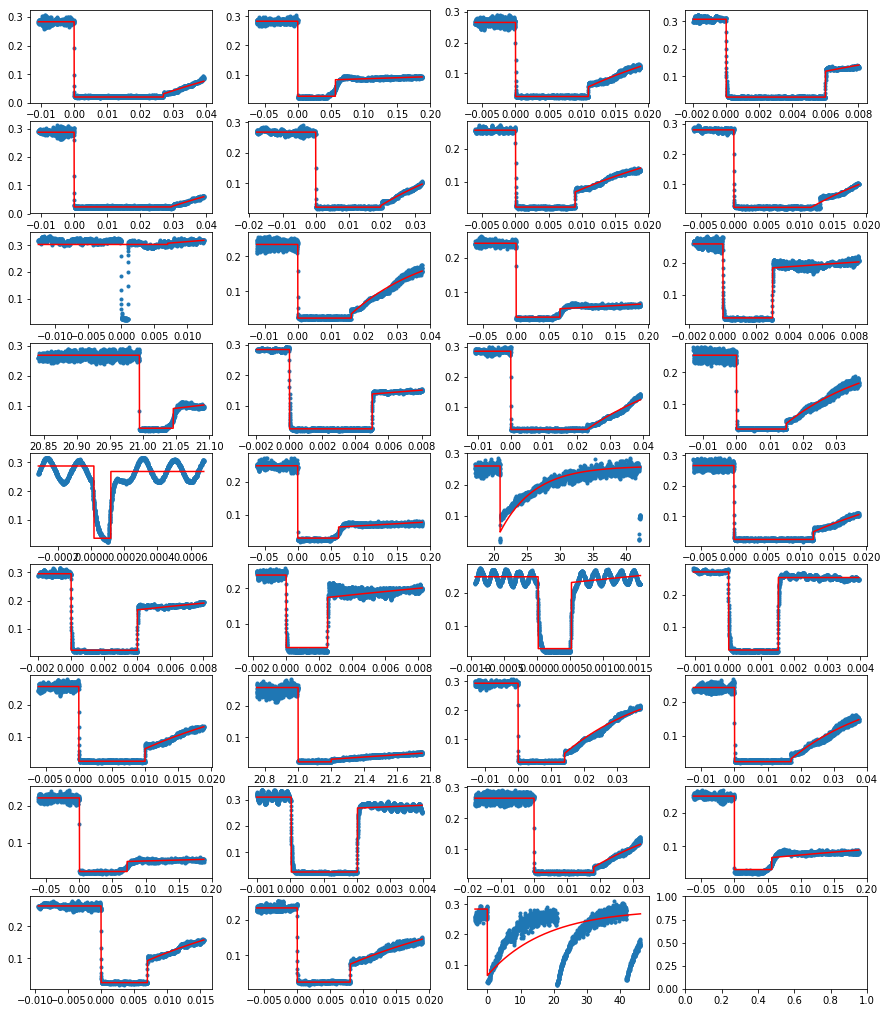

In [30]:
dfs_fit_rr, fit_df_rr = fit_loading_dfs(dfs_rr, offset_on=True)
fig, axes = plot_dfs_with_fits(dfs_fit_rr)

In [123]:
fit_df_rr

,amp,offset,redchi,tau
file,,,,
TEK0000,0.212444,5.507829e-02,0.000107,31.744203
TEK0001,0.164936,0.000000e+00,0.003157,3.045262
TEK0002,0.239549,6.521656e-02,0.000094,0.963138
TEK0003,0.192902,1.055991e-02,0.000400,4.879575
TEK0004,0.284127,2.683848e-01,0.000076,0.245461
TEK0005,0.285495,2.477073e-01,0.000219,0.599232
TEK0006,0.210273,1.961406e-01,0.000346,0.009398
TEK0007,0.245332,2.239176e-01,0.000138,0.052174
TEK0008,0.215922,1.872567e-01,0.000942,0.003046
